<h1>BCG - Data Science and Analytics Experience Program</h1>

<h4>PowerCo is a BCG client company that provides energy and gas to SMEs (Small and Medium Enterprises) as well as residences but has been experiencing customer churn issues. One plausible hypothesis for customer churn is the impact of price sensitivity and challenges related to power liberalization in the European market, specially during the period between January and March 2016. The bjective is to gain a deeper understanding of the data and extract actionable insights from this hypothesis. We aim to assess whether the current marketing strategy employed by PowerCo — providing a 20% discount to churned customers — is effective. This notebook describes the process of Exploratory Data Analysis (EDA) to examine the primary reasons for churn and determine whether they are related to the previously mentioned hypothesis.


The analysis is conducted using two datasets, containing information about the customers and prices.
</h4>

<h3>0. Importing the libraries and defining base functions.</h3>

In [1]:
#Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

Definition of the functions used in the code

In [2]:

def plot_hist_variaveis(conjunto, dataframe, i=0, legend=None, title='distribuição das variáveis numéricas'):
    
    '''
    Essa função plota uma série de histogramas a partir de um dado
    conjunto de colunas em um dataframe, o conjunto deve ser passado como
    uma lista. É possível criar segmentação nos dados através do parâmetro
    'legend', além disso também é possível alterar o título do gráfico
    através do parâmetro 'title'.
    '''

    total_plots = len(conjunto)
    fig = plt.figure(figsize=(20,6*total_plots))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(title, y=0.895)


    for var in conjunto:
        mean = dataframe[var].mean()
        max = dataframe[var].max()
        first_quartile = dataframe[var].quantile(0.25)
        third_quartile = dataframe[var].quantile(0.75)
        ax = fig.add_subplot(total_plots, 2, i+1)
        if legend is not None:
            sns.histplot(x=dataframe[var], ax=ax, color='#435058', hue=dataframe[legend], alpha=0.5, kde=True)
        else:
            sns.histplot(x=dataframe[var], ax=ax, color='#435058', alpha=0.5,  kde=True)
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.axvline(mean, color='r', linestyle='--')
        ax.axvline(first_quartile, color='g', linestyle='--')
        ax.axvline(third_quartile, color='g', linestyle='--')
        ax.text(ax.get_xlim()[0], ax.get_ylim()[1]+((ax.get_ylim()[1])/11), 'Média: {:.2f}'.format(mean))
        ax.text(ax.get_xlim()[0], ax.get_ylim()[1]+((ax.get_ylim()[1])/20), 'Máximo: {:.2f}'.format(max))
        
        i += 1

def plot_bar_variaveis(conjunto, dataframe, x_var, i=0, title='distribuição das variáveis numéricas', legend=None, annotate=None):
    
    '''
    Essa função plota uma série de barras a partir de um dado
    conjunto de colunas em um dataframe, o conjunto deve ser passado como
    uma lista. É possível criar segmentação nos dados através do parâmetro
    'legend', além disso também é possível alterar o título do gráfico
    através do parâmetro 'title'. O parâmetro 'annotate' coloca o label
    nas barras.
    '''

    total_plots = len(conjunto)
    fig = plt.figure(figsize=(20,6*total_plots))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(title, y=0.895)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)
        #dataframe = dataframe.groupby(x_var).mean()

        if legend is not None:
            sns.barplot(y=dataframe[var], ax=ax, x=dataframe[x_var], hue=dataframe[legend])
        else:
            sns.barplot(y=dataframe[var], ax=ax, x=dataframe[x_var])

        if annotate:
            for p in ax.patches:
                x = p.get_x() + p.get_width()/2
                y = p.get_height()
                ax.annotate(f'{y:.2}', (x, y), ha='center', va='bottom', fontsize=10)
            
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')


        i += 1

def create_log_variable (conjunto, dataframe):
    '''
    Função simples que aceita um conjunto de colunas em 
    um dataframe e cria novas colunas com as versões logaritmicas
    dessas. Aceita apenas colunas numéricas e, em caso de 0, não
    realiza nenhuma alteração no valor.
    '''

    for var in conjunto:
        dataframe[var+'_log'] = dataframe[var].apply(lambda x: np.log(x) if x > 0 else 0)
    return dataframe

def normalization_test (conjunto, dataframe, alpha=0.05):
    '''
    Dado um conjunto de colunas em um dataframe, realiza
    testes de normalização a partir de Shapiro-Wilk e retorna 
    se o teste refuta ou não a hipótese nula. (H0 = Normal distribution)
    '''
    for col in conjunto:
        statistic, p_value = stats.shapiro(dataframe[col])
        if p_value > alpha:
            print(col, 'H0: Normal distribution')
        else:
            print(col, 'H1: Non-normal distribution')

def plot_bar_percentages(dataframe, var, rotation=0, fig=None, ax=None):
    ''' 
    Dada uma determinada coluna de um dataframe, devolve um gráfico
    de barras com os valores percentuais dos valores únicos da coluna.
    Pode ser configurado dentro de uma figura, se os parâmetros de figura
    e axis forem fornecidos
    '''
    count_dataframe = dataframe[[var]].value_counts().reset_index(name='count')
    count_dataframe['percentage'] = count_dataframe['count'] / count_dataframe['count'].sum()

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=var, y='percentage', data=count_dataframe)
    else:
        sns.barplot(x=var, y='percentage', data=count_dataframe, ax=ax)

    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(f'{y:.2%}', (x, y), ha='center', va='bottom', fontsize=10)
 
    
    plt.xticks(rotation=rotation)

    

<h3>1. CSV files import and merge.</h3>

In [3]:
#Two datasets are provided, one related to customers and the other to product prices.
dir_price = 'price_data.csv'
dir_client = 'client_data.csv'

df_price = pd.read_csv(dir_price)
df_client = pd.read_csv(dir_client)

In [4]:
#It was considered that the information loss due to the merging of CSVs would be low, given the number of rows. Therefore, the dataframes were joined to improve readability.
for dataframe in [df_client, df_price]:
    print(dataframe['id'].nunique())
    print(dataframe.shape)

df = df_client.merge(df_price, how='inner', on='id')
print(df['id'].nunique())
print(df.shape)

14606
(14606, 26)
16096
(193002, 8)
14606
(175149, 33)


<h3>2. Dataframe manipulation</h3>

In [20]:
#Checking information about the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175149 entries, 0 to 175148
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              175149 non-null  object        
 1   channel_sales                   175149 non-null  int64         
 2   cons_12m                        175149 non-null  int64         
 3   cons_gas_12m                    175149 non-null  int64         
 4   cons_last_month                 175149 non-null  int64         
 5   date_activ                      175149 non-null  datetime64[ns]
 6   date_end                        175149 non-null  datetime64[ns]
 7   date_modif_prod                 175149 non-null  datetime64[ns]
 8   date_renewal                    175149 non-null  datetime64[ns]
 9   forecast_cons_12m               175149 non-null  float64       
 10  forecast_cons_year              175149 non-null  int64  

In [6]:
#Removing duplicates
df = df.drop_duplicates()

In [7]:
#Columns "channel_sales" and "origin_up" have values with messy names that provide little information. Therefore, numeric codes were assigned to enhance their understanding.
for var in ['channel_sales','origin_up']:
    df[var] = df[var].factorize()[0]

In [8]:
#Given that the dates have daily values, I created columns with annual values for date-type variables to simplify subsequent reading.
for var in ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']:
    df[var] = pd.to_datetime(df[var], format='%Y-%m-%d')


df['year_activ'] = df['date_activ'].dt.year
df['year_renewal'] = df['date_renewal'].dt.year
df['year_modif_prod'] = df['date_modif_prod'].dt.year
df['year_end'] = df['date_end'].dt.year


<h3>3. Data Visualization and insights</h3>

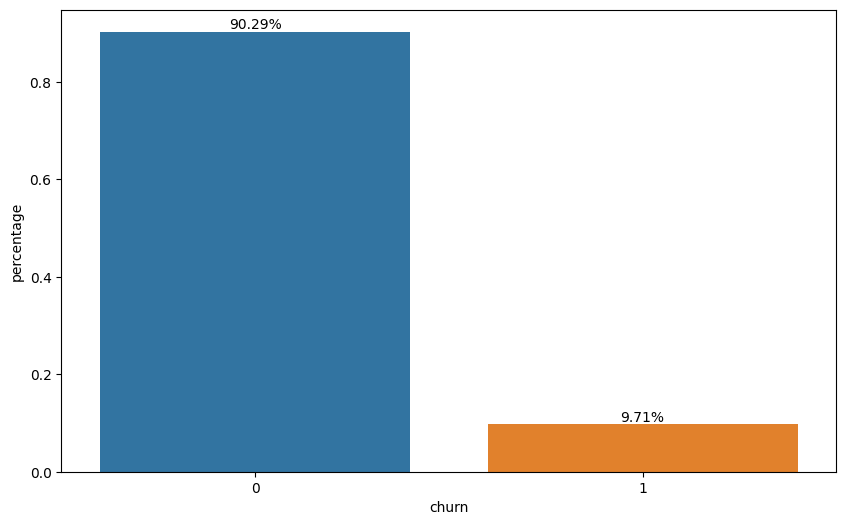

In [9]:
plot_bar_percentages(dataframe=df, var='churn')

<h4>The first step in the analysis is to indentify the problem. In this case, approximately 10% of the customers experienced churn during the period.</h4>

In [10]:
#I separated the dataframe into two based on whether churn occurred or not. The intention here is to comparatively analyze some numerical variables to examine quantitative differences between the groups.

df_had_churn = df[df['churn'] == 1]
df_not_churn = df[df['churn'] == 0]

Text(0.5, 1.0, 'Not Churn')

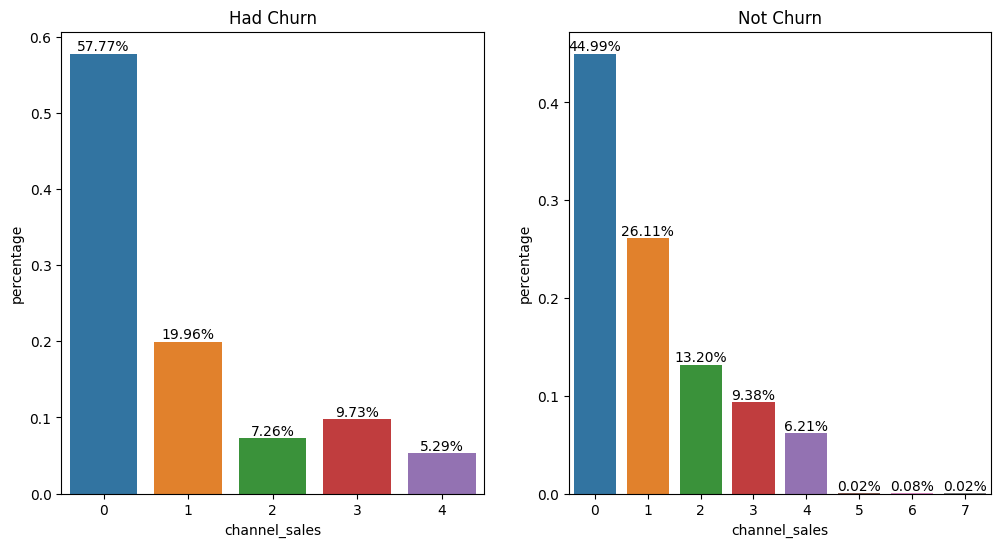

In [11]:
#Plotting the segment through which customers made their purchases.
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_bar_percentages(df_had_churn, 'channel_sales', fig=fig, ax=ax[0])
plot_bar_percentages(df_not_churn, 'channel_sales', fig=fig, ax=ax[1])
ax[0].set_title('Had Churn')
ax[1].set_title('Not Churn')

<h4>
Most of the customers who churned made their purchases through channel 0. Channels 5, 6, and 7 did not have much expression in purchases. The distribution of the participation among the purchase channels for customers who churned or not is relatively similar, indicating that there may not be a very strong correlation between the purchase channel and the possibility of churn in this case.</h4>

Text(0.5, 1.0, 'Not Churn')

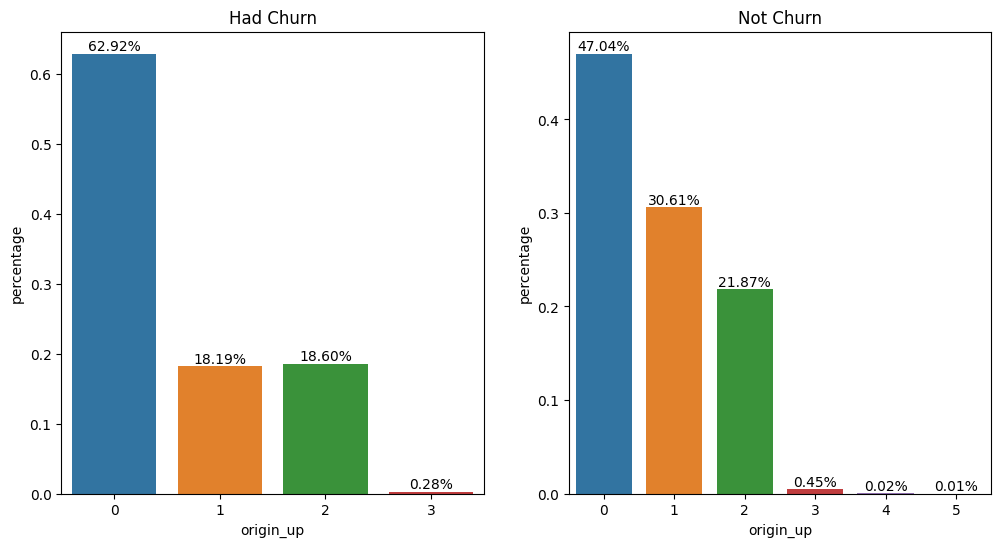

In [12]:
#Plotting the offer through which customers obtained the product.
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_bar_percentages(df_had_churn, 'origin_up', fig=fig, ax=ax[0])
plot_bar_percentages(df_not_churn, 'origin_up', fig=fig, ax=ax[1])
ax[0].set_title('Had Churn')
ax[1].set_title('Not Churn')

<h4>Offers 0, 1, and 2 had higher new customer adoption. Campaign 1 shows success in retaining customers, maintaining a significantly high percentage among the current customer base. More than half of the customers who churned obtained the product through campaign 0.</h4>

Text(0.5, 1.0, 'Not Churn')

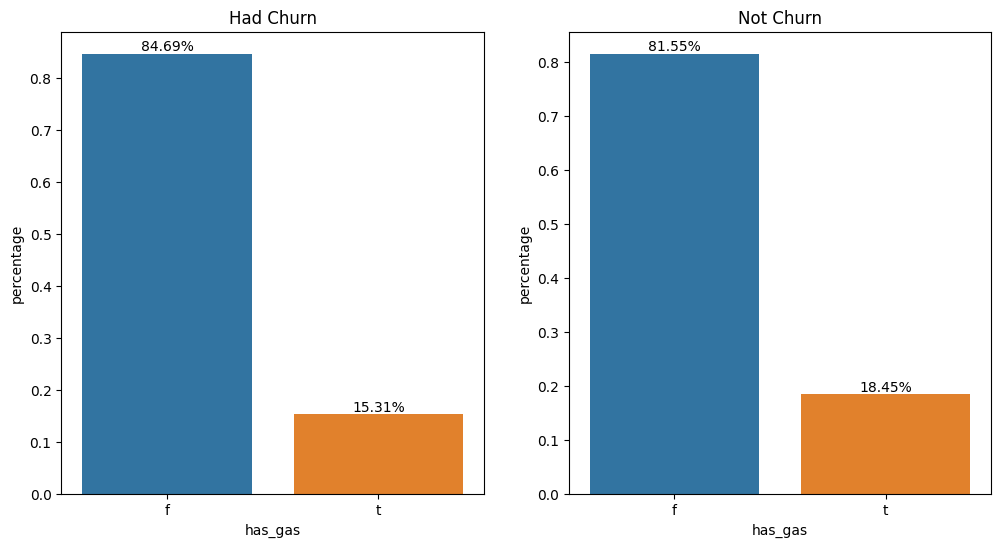

In [13]:
#Plotting the percentage of customers with gas energy.
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_bar_percentages(df_had_churn, 'has_gas', fig=fig, ax=ax[0])
plot_bar_percentages(df_not_churn, 'has_gas', fig=fig, ax=ax[1])
ax[0].set_title('Had Churn')
ax[1].set_title('Not Churn')

<h4>There is no substantial difference in the profile between customers, indicating that consuming gas energy is not a differentiating factor in predicting churn.</h4>

Text(0.5, 0.98, 'Alterações no contrato de serviço por ano')

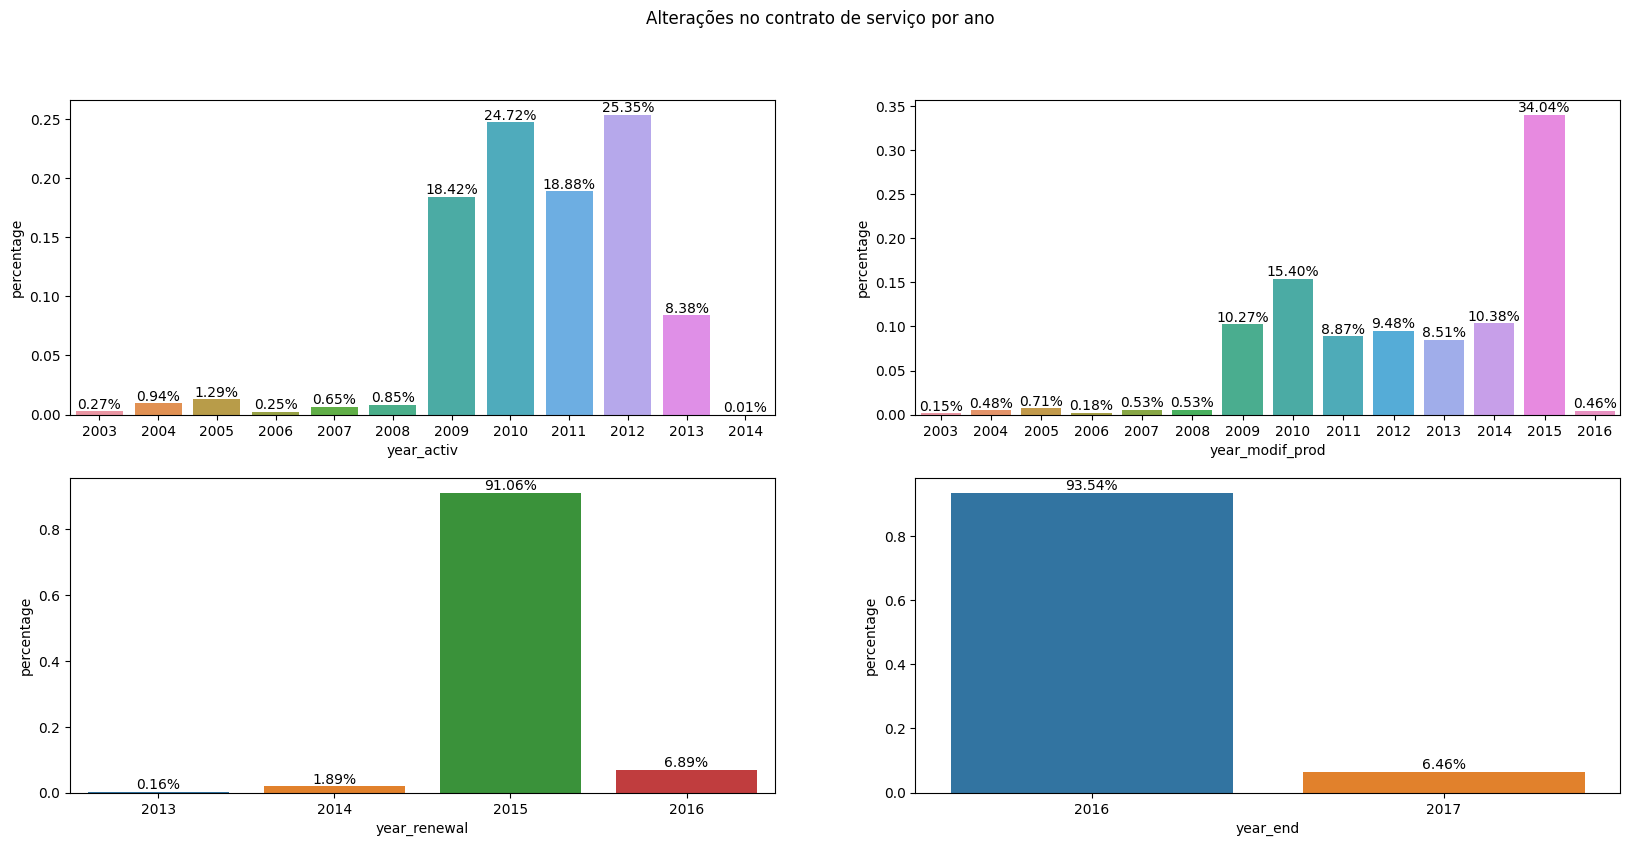

In [14]:
#Plotting service contract changes per year. 
fig, ax = plt.subplots(figsize=(20, 9), ncols=2, nrows=2)
plot_bar_percentages(df, 'year_activ', fig=fig, ax=ax[0][0])
plot_bar_percentages(df, 'year_modif_prod', fig=fig, ax=ax[0][1])
plot_bar_percentages(df, 'year_renewal', fig=fig, ax=ax[1][0])
plot_bar_percentages(df, 'year_end', fig=fig, ax=ax[1][1])

'''for ax_ in ax:
    ax_.tick_params(axis='x', rotation=90)'''

fig.suptitle('Service contract changes per year.')

<h4>A turning point is observed in 2015, as it is the year with the majority of contract modifications and renewals. The year 2016 marks the period of the majority of churn, suggesting that it <u>could be a year of contract renewal for many customers</u> (given that numerous contracts were renewed in 2015, it is intuitive to assume a similar trend in the following year). Additionally, churn in 2016 might indicate dissatisfaction with contract modifications in previous years or with the contract renewals conducted earlier, <u>it also goes in line with the previous information about the energy market change in 2016</u>. Considering that contract renewals typically involve changes in values, a plausible hypothesis is that the values set in the new contracts were not attractive to a considerable number of customers, <u>which goes along with the price sensitivity hypothesis</u>.</h4>

Text(0.5, 0.98, 'Energy price variation')

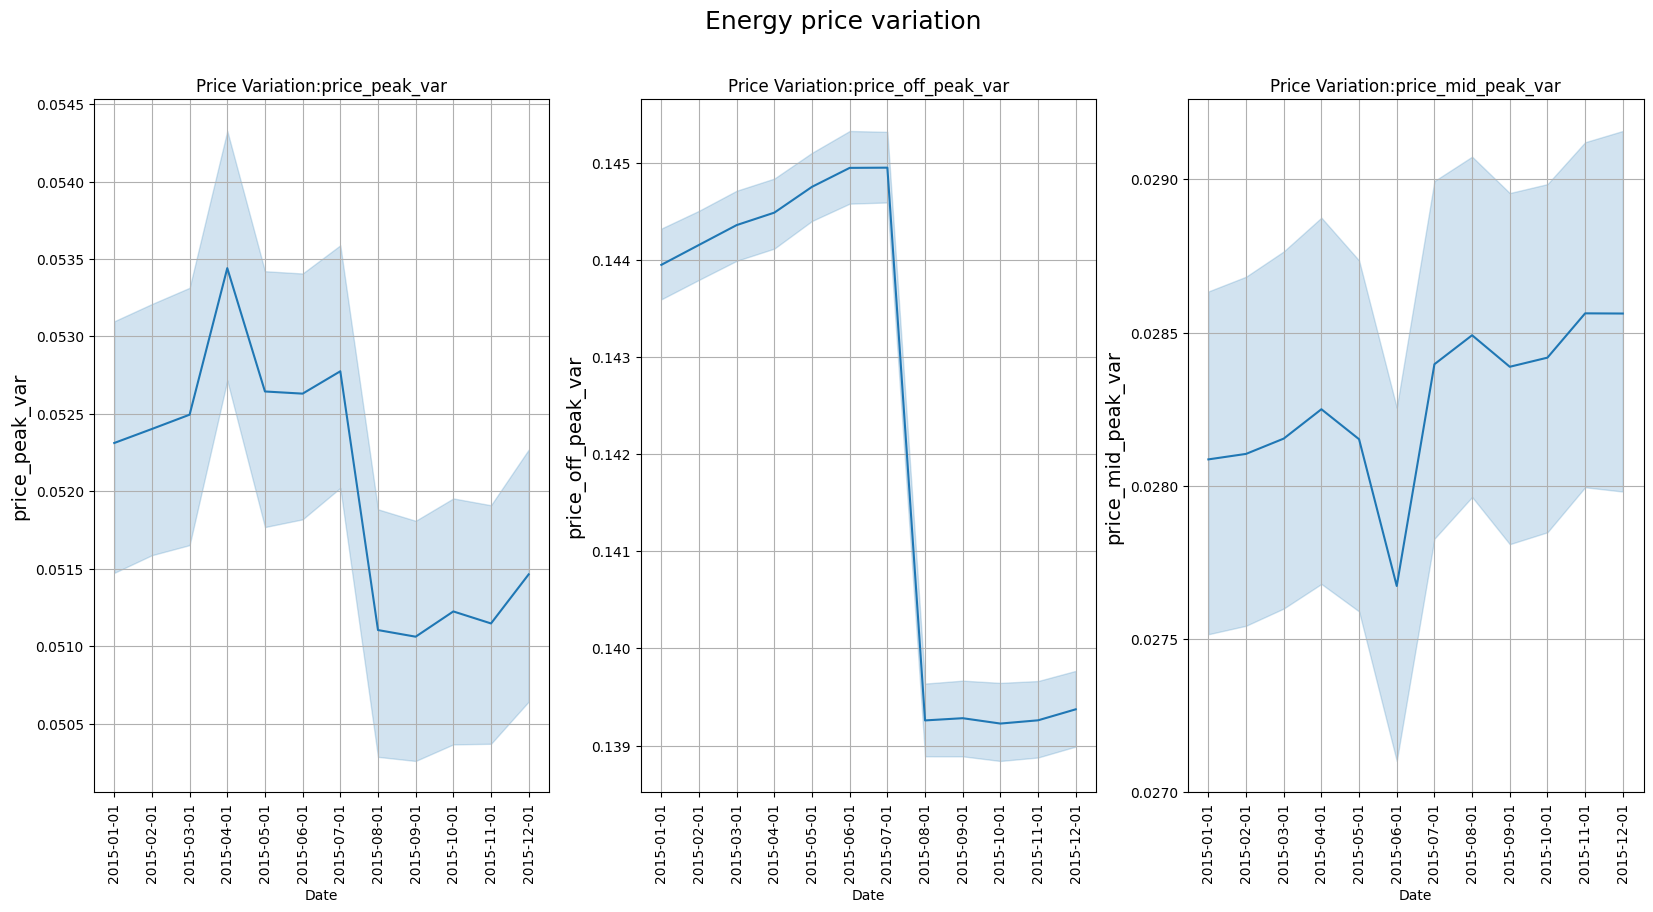

In [15]:
#Plotting variations in energy prices.
fig, ax = plt.subplots(figsize=(20, 9), nrows=1, ncols=3)
sns.lineplot(x='price_date', y='price_peak_var', data=df, ax=ax[0])
sns.lineplot(x='price_date', y='price_off_peak_var', data=df, ax=ax[1])
sns.lineplot(x='price_date', y='price_mid_peak_var', data=df, ax=ax[2])

for ax_ in ax:
    ax_.set_xlabel('Date')
    ax_.set_ylabel(ax_.get_ylabel(), fontsize=14)
    ax_.set_title('Price Variation:' + ax_.get_ylabel())
    ax_.tick_params(axis='x', rotation=90)
    ax_.grid(True)

fig.suptitle('Energy price variation', fontsize=18)

#%%

Text(0.5, 0.98, 'Power price variation')

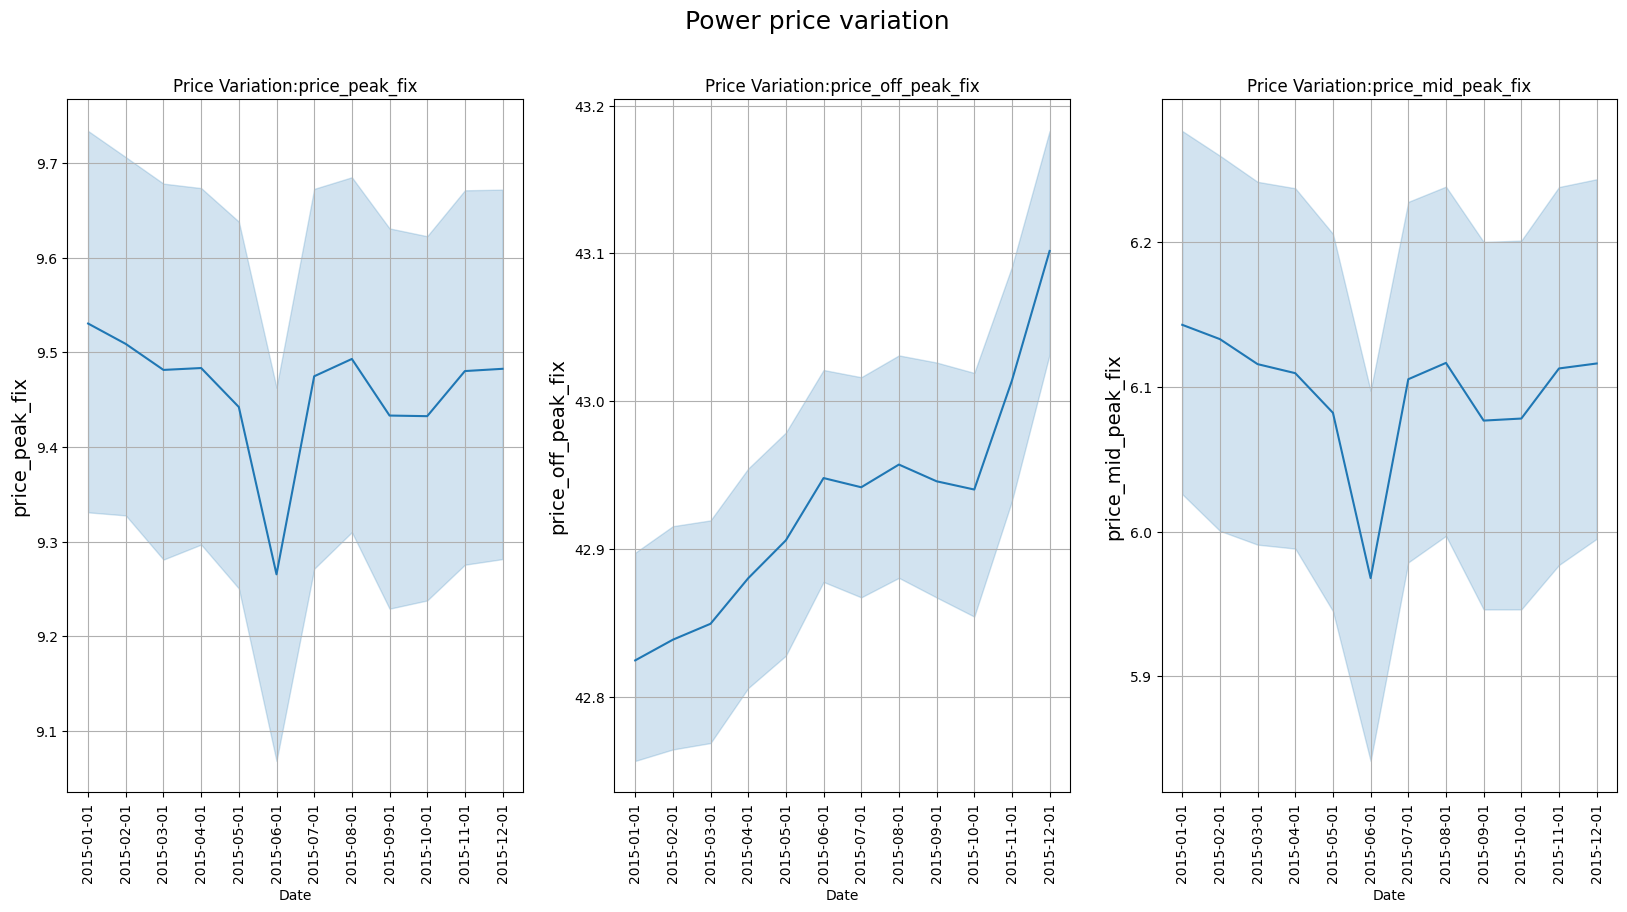

In [16]:
#Plotting variations in power prices.
fig, ax = plt.subplots(figsize=(20, 9), nrows=1, ncols=3)
sns.lineplot(x='price_date', y='price_peak_fix', data=df, ax=ax[0])
sns.lineplot(x='price_date', y='price_off_peak_fix', data=df, ax=ax[1])
sns.lineplot(x='price_date', y='price_mid_peak_fix', data=df, ax=ax[2])

for ax_ in ax:
    ax_.set_xlabel('Date')
    ax_.set_ylabel(ax_.get_ylabel(), fontsize=14)
    ax_.set_title('Price Variation:' + ax_.get_ylabel())
    ax_.tick_params(axis='x', rotation=90)
    ax_.grid(True)

fig.suptitle('Power price variation', fontsize=18)

<h4>The inspection of the graphs indicates the off-peak power price increased considerably during 2015. The increase in <u>the off-peak consumption price may be indicative of its relationship with the churn movement in 2016.</u> If the relationship is confirmed, the off-peak electricity price would be the most decisive factor in customer decision-making, which makes sense considering that the tariff remains in this range for most of the day. <u>The off-peak price increased most during the three last months of 2015, near the date of electric market change, which could accentuate customer dissatisfaction at that moment</u> </h4>

In [18]:
#I separated some groups of variables and grouped the numerical values by the average based on the churn condition. The purpose here is to check if there are 
#substantial differences between the groups for some of these variables.
vars_consumption = ['cons_12m', 'cons_gas_12m', 'cons_last_month']
vars_consumption_prev = ['forecast_cons_12m', 'forecast_cons_year']
vars_consumption_paid = ['imp_cons']
vars_margin = ['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin']
vars_product = ['num_years_antig', 'nb_prod_act', 'pow_max']
vars_price = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']

df_churn_mean = df.groupby('churn', as_index=False).mean(numeric_only=True)

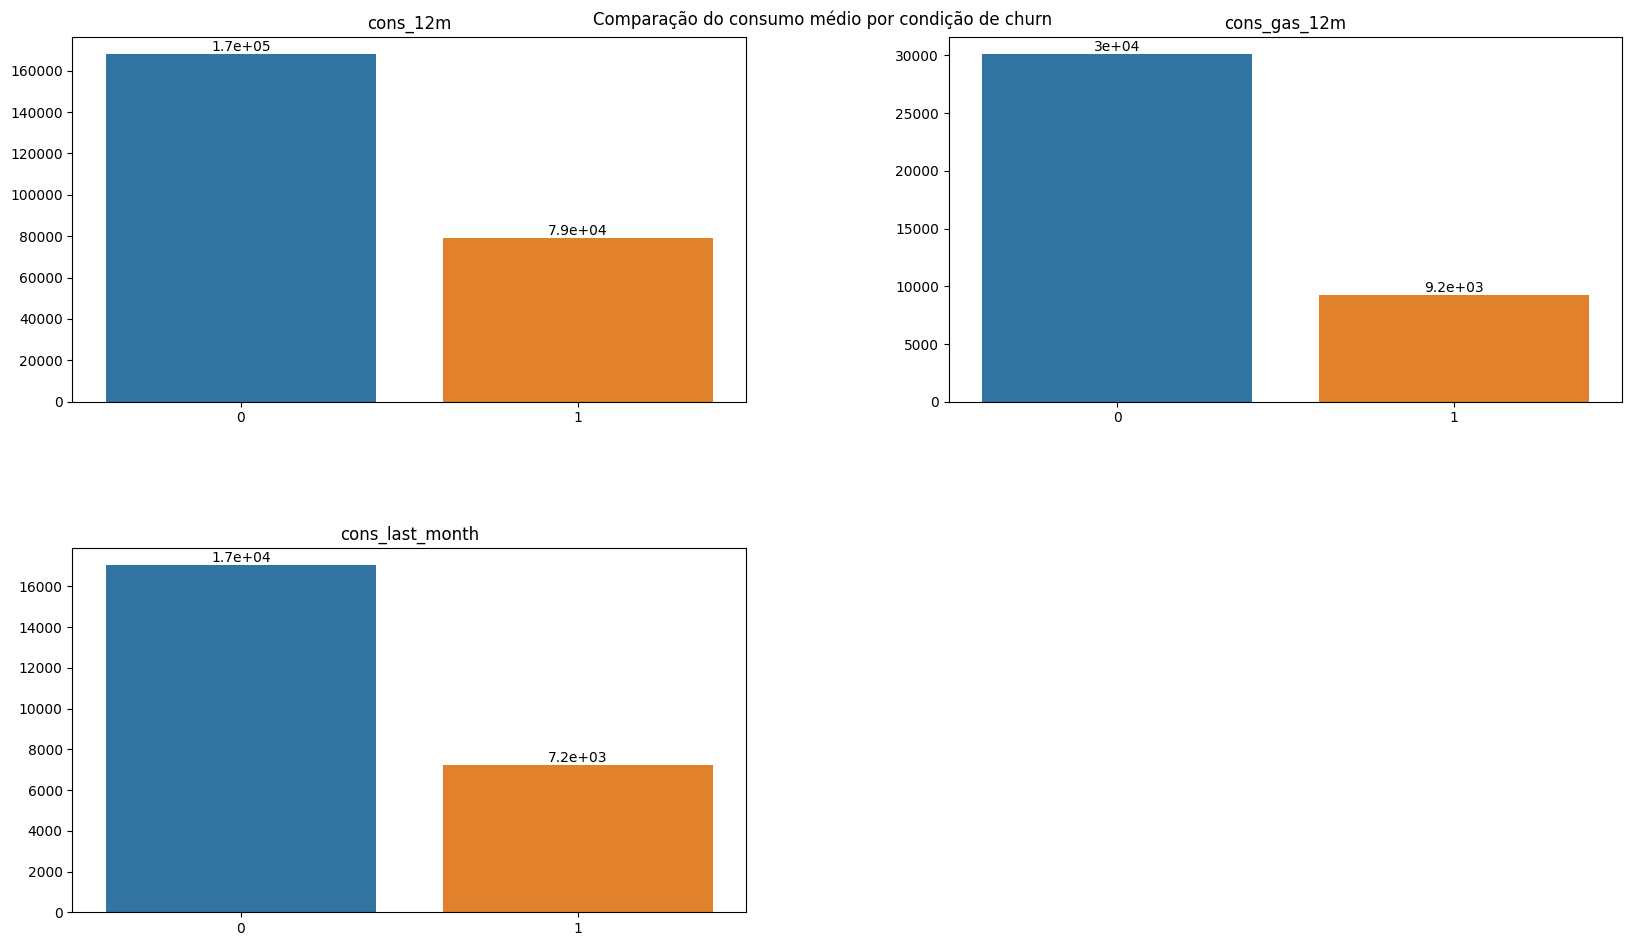

In [19]:
plot_bar_variaveis(conjunto=vars_consumption, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparison of average consumption by churn condition')

<h4><u>The average consumption in the last 12 months and the last month was considerably lower among customers who churned.</u> This is an important finding as it allows investigating possible new candidates for churn based on their consumption in recent months. It is also interesting to consider <u>whether the decrease in consumption is related to the price increase.</u> In this sense, it is reasonable to think that companies more affected by price increases reduce their consumption more and occasionally switch suppliers. There is also the hypothesis that <u>smaller customers - and probably those with lower consumption - are more affected by price increases and therefore churn more.</u> However, it is challenging to confirm this hypothesis as there is limited information about the customers. Consumption data was provided in absolute values; therefore, a data point related to the customer's occupation or area could help create an indicator, improving the assessment of churn.</h4>

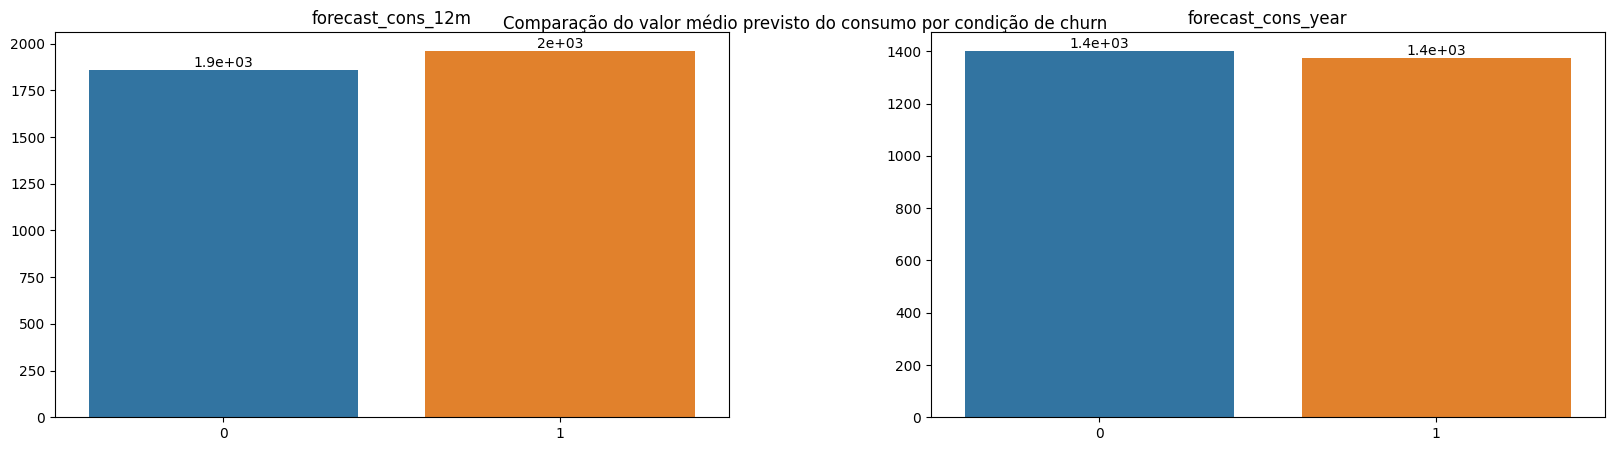

In [ ]:
plot_bar_variaveis(conjunto=vars_consumption_prev, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparison of the predicted average value of consumption by churn condition.')

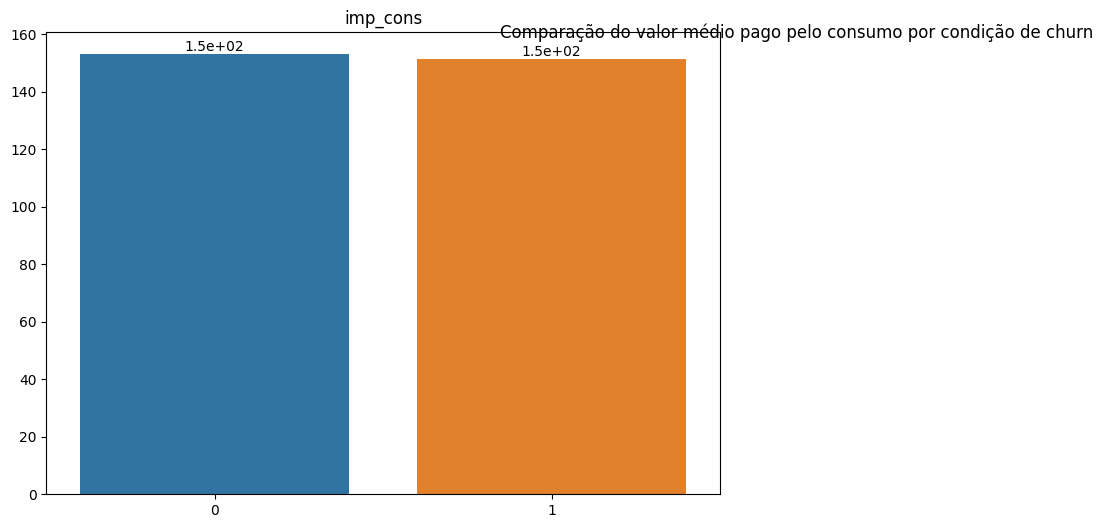

In [ ]:
plot_bar_variaveis(conjunto=vars_consumption_paid, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparison of the average amount paid for consumption by churn condition.')

<h4>There is no significant difference in the predicted consumption for the upcoming periods among customers based on churn distinction. This investigation indicates that <u>the lower consumption of customers who churned should not be related to the size of the companies or their consumption needs</u>. If this hypothesis were true, <u>the predicted consumption for the next months would be considerably lower among customers who churned</u>. Thus, it is possible to state - prematurely - that <u>the low consumption among customers who churned was a deviation from the previous consumption trend of these same customers</u>.</h4>

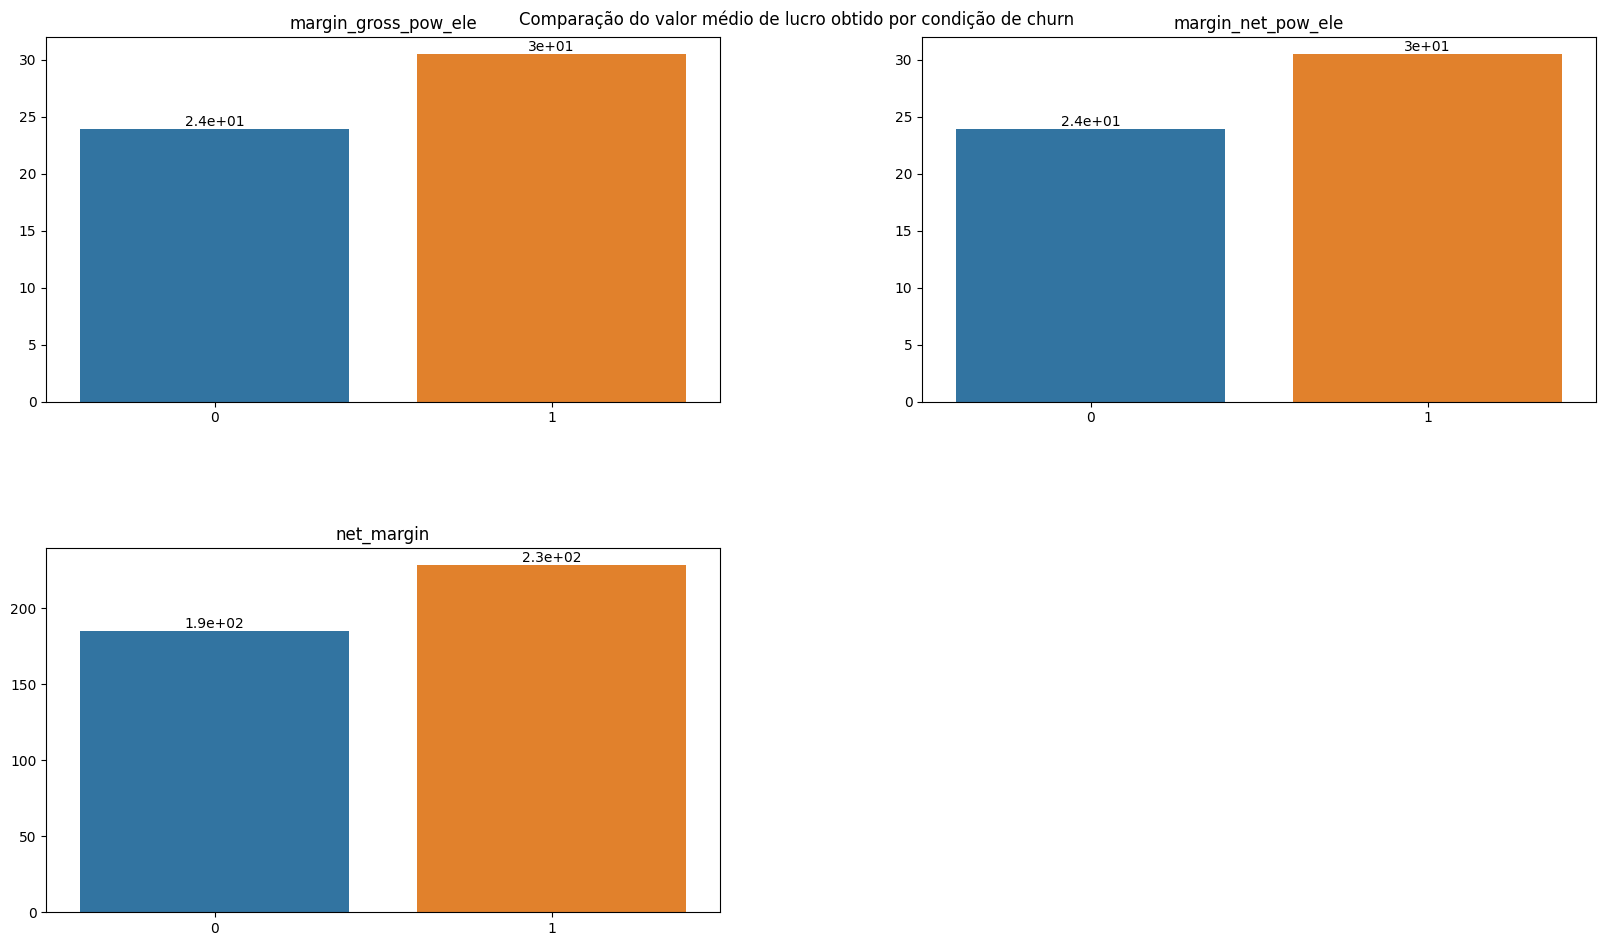

In [ ]:
plot_bar_variaveis(conjunto=vars_margin, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparison of the average profit obtained by churn condition.')

<h4><u>The company's profit margin is higher among customers who later churned.</u> This may indicate that these customers have opted for less advantageous promotions or are proportionally paying more for consumption. However, it may also be related to specific customer issues. It is also an indication that <u>the company can offer promotions in these cases to prevent churn, taking advantage of a higher initial profit margin</u>.</h4>

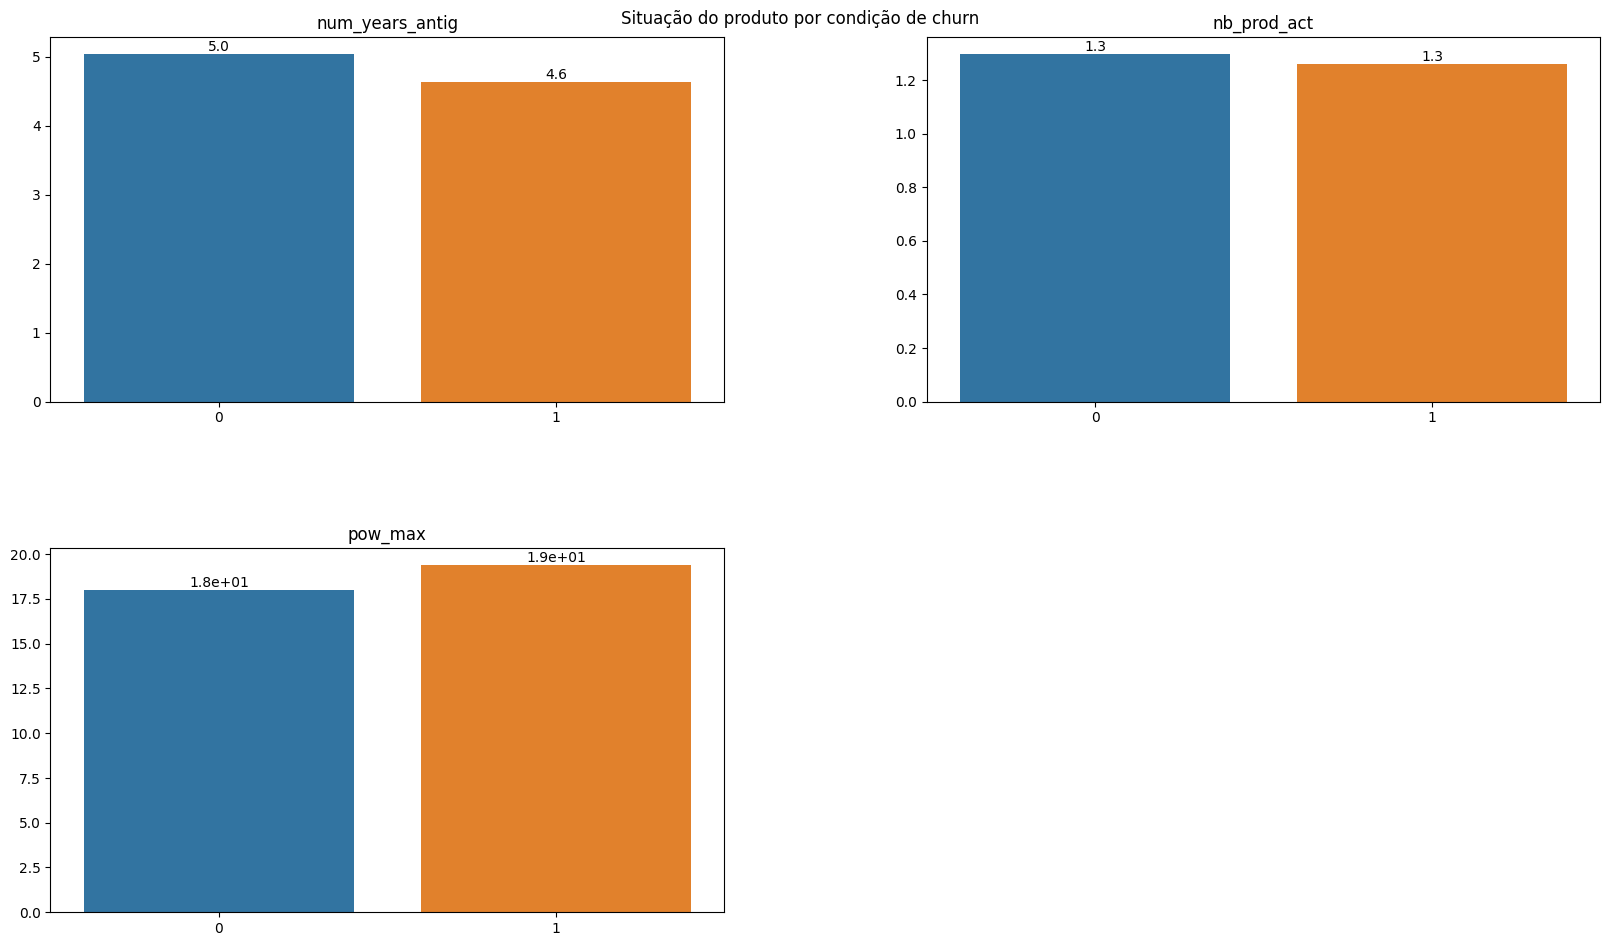

In [ ]:
plot_bar_variaveis(conjunto=vars_product, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Product status by churn condition.')

<h4>The condition of customer characteristics is relatively similar concerning the active contract period and the number of products purchased; the contracted power quantity is also similar. In this case, <u>the equality in contracted power stands out, given that the consumption among customers who churned is considerably lower.</u></h4>

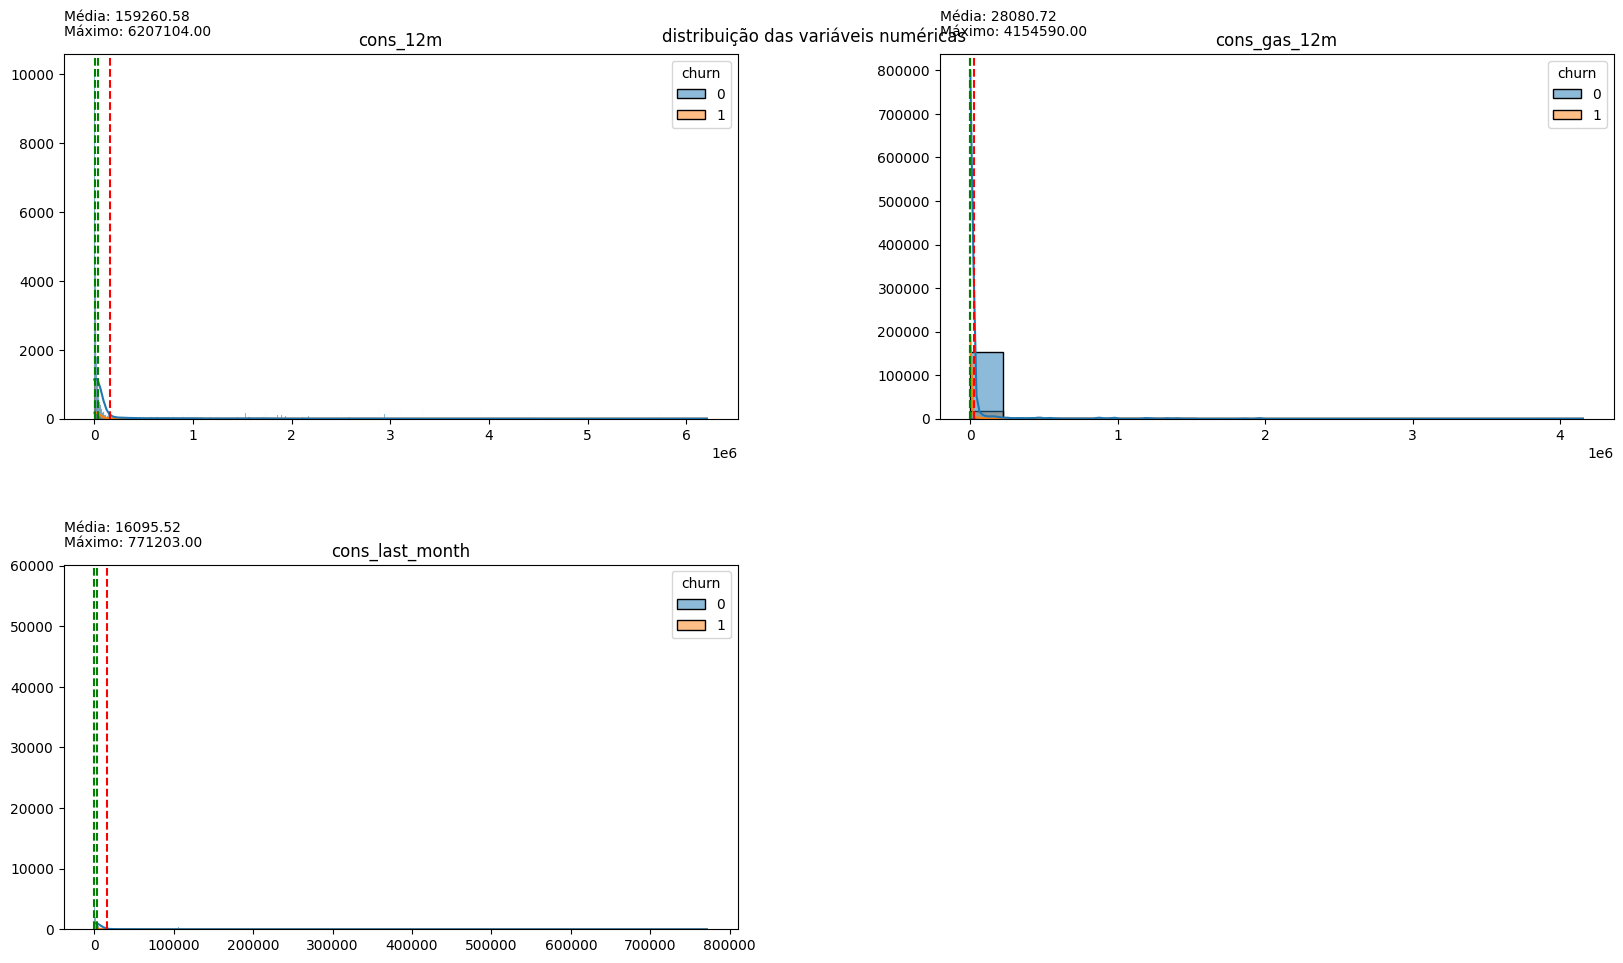

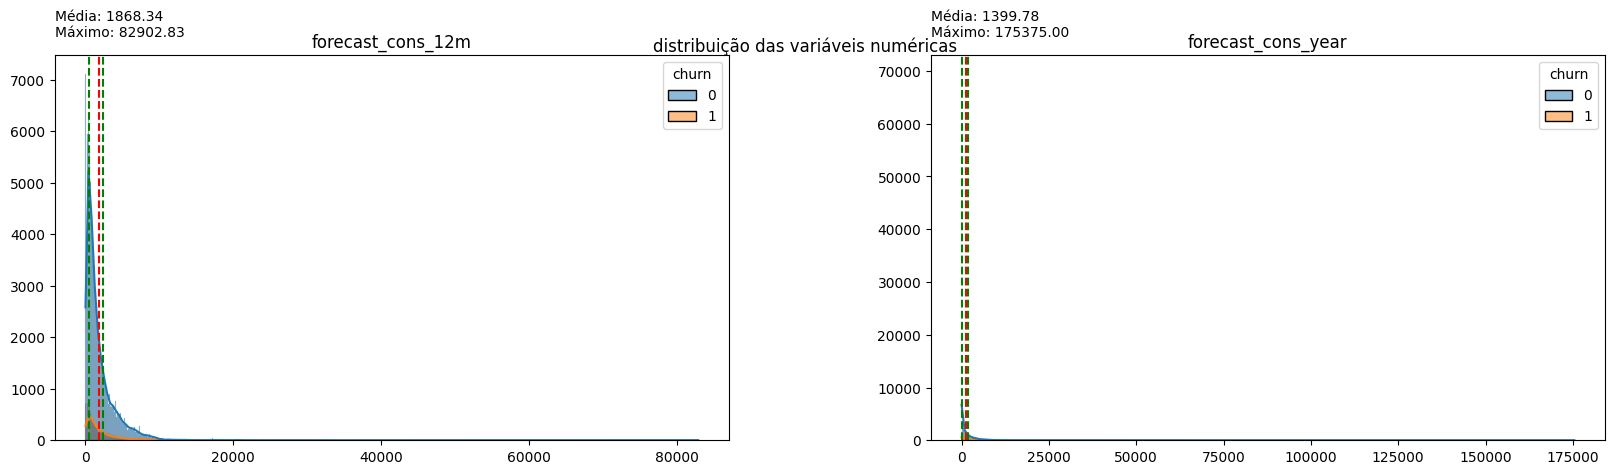

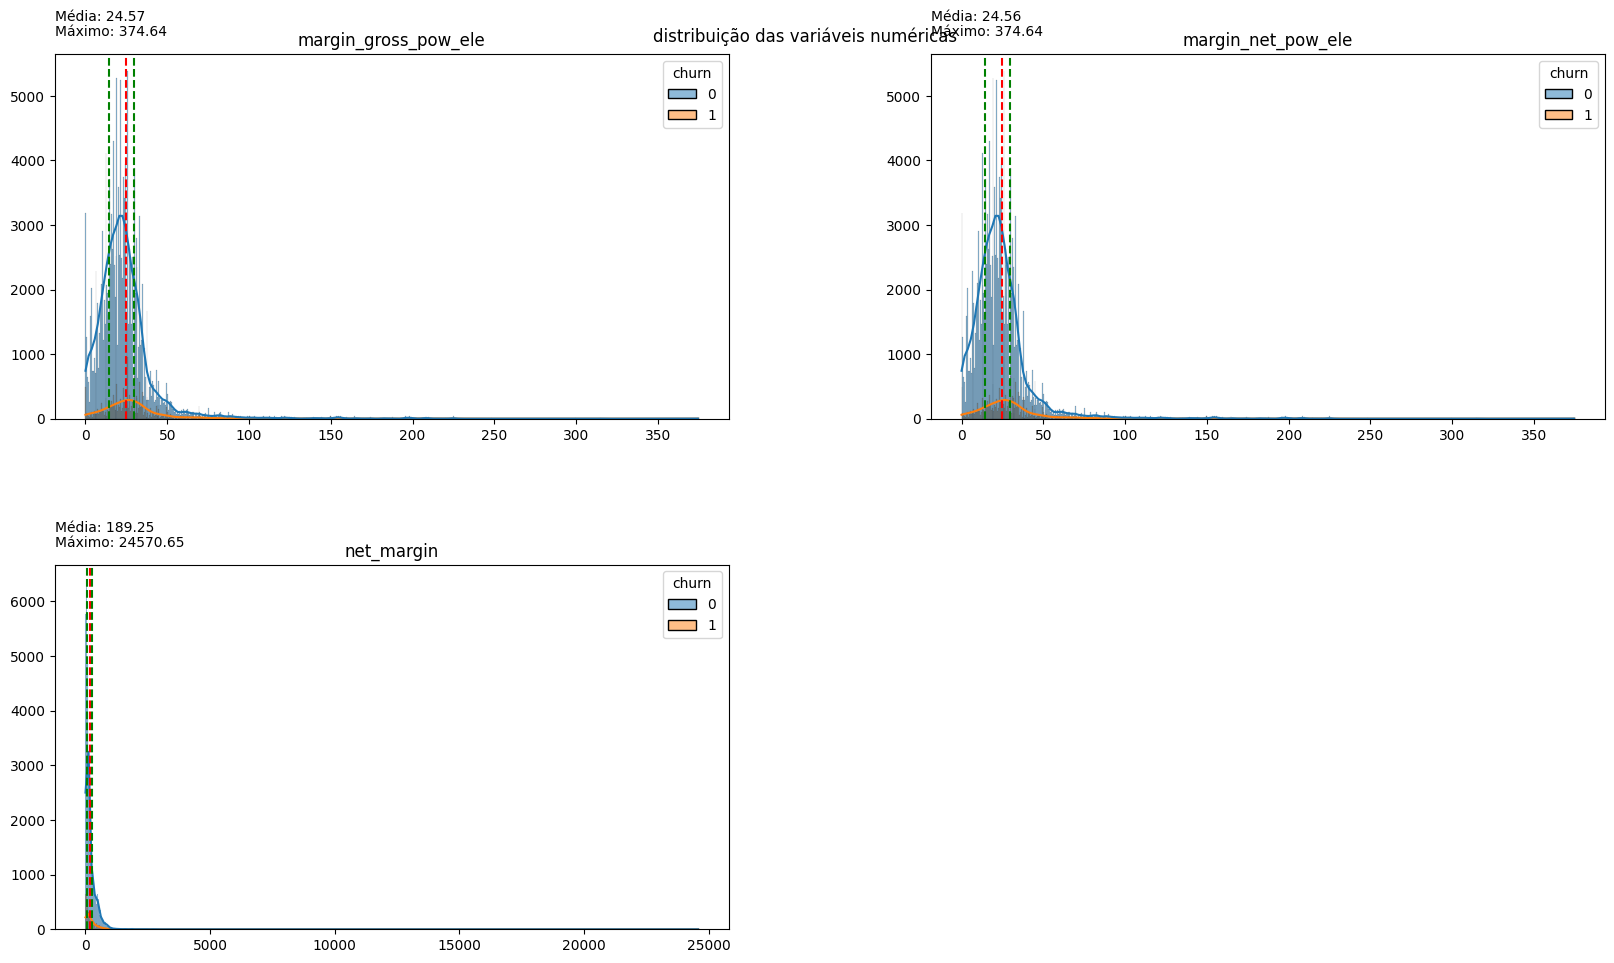

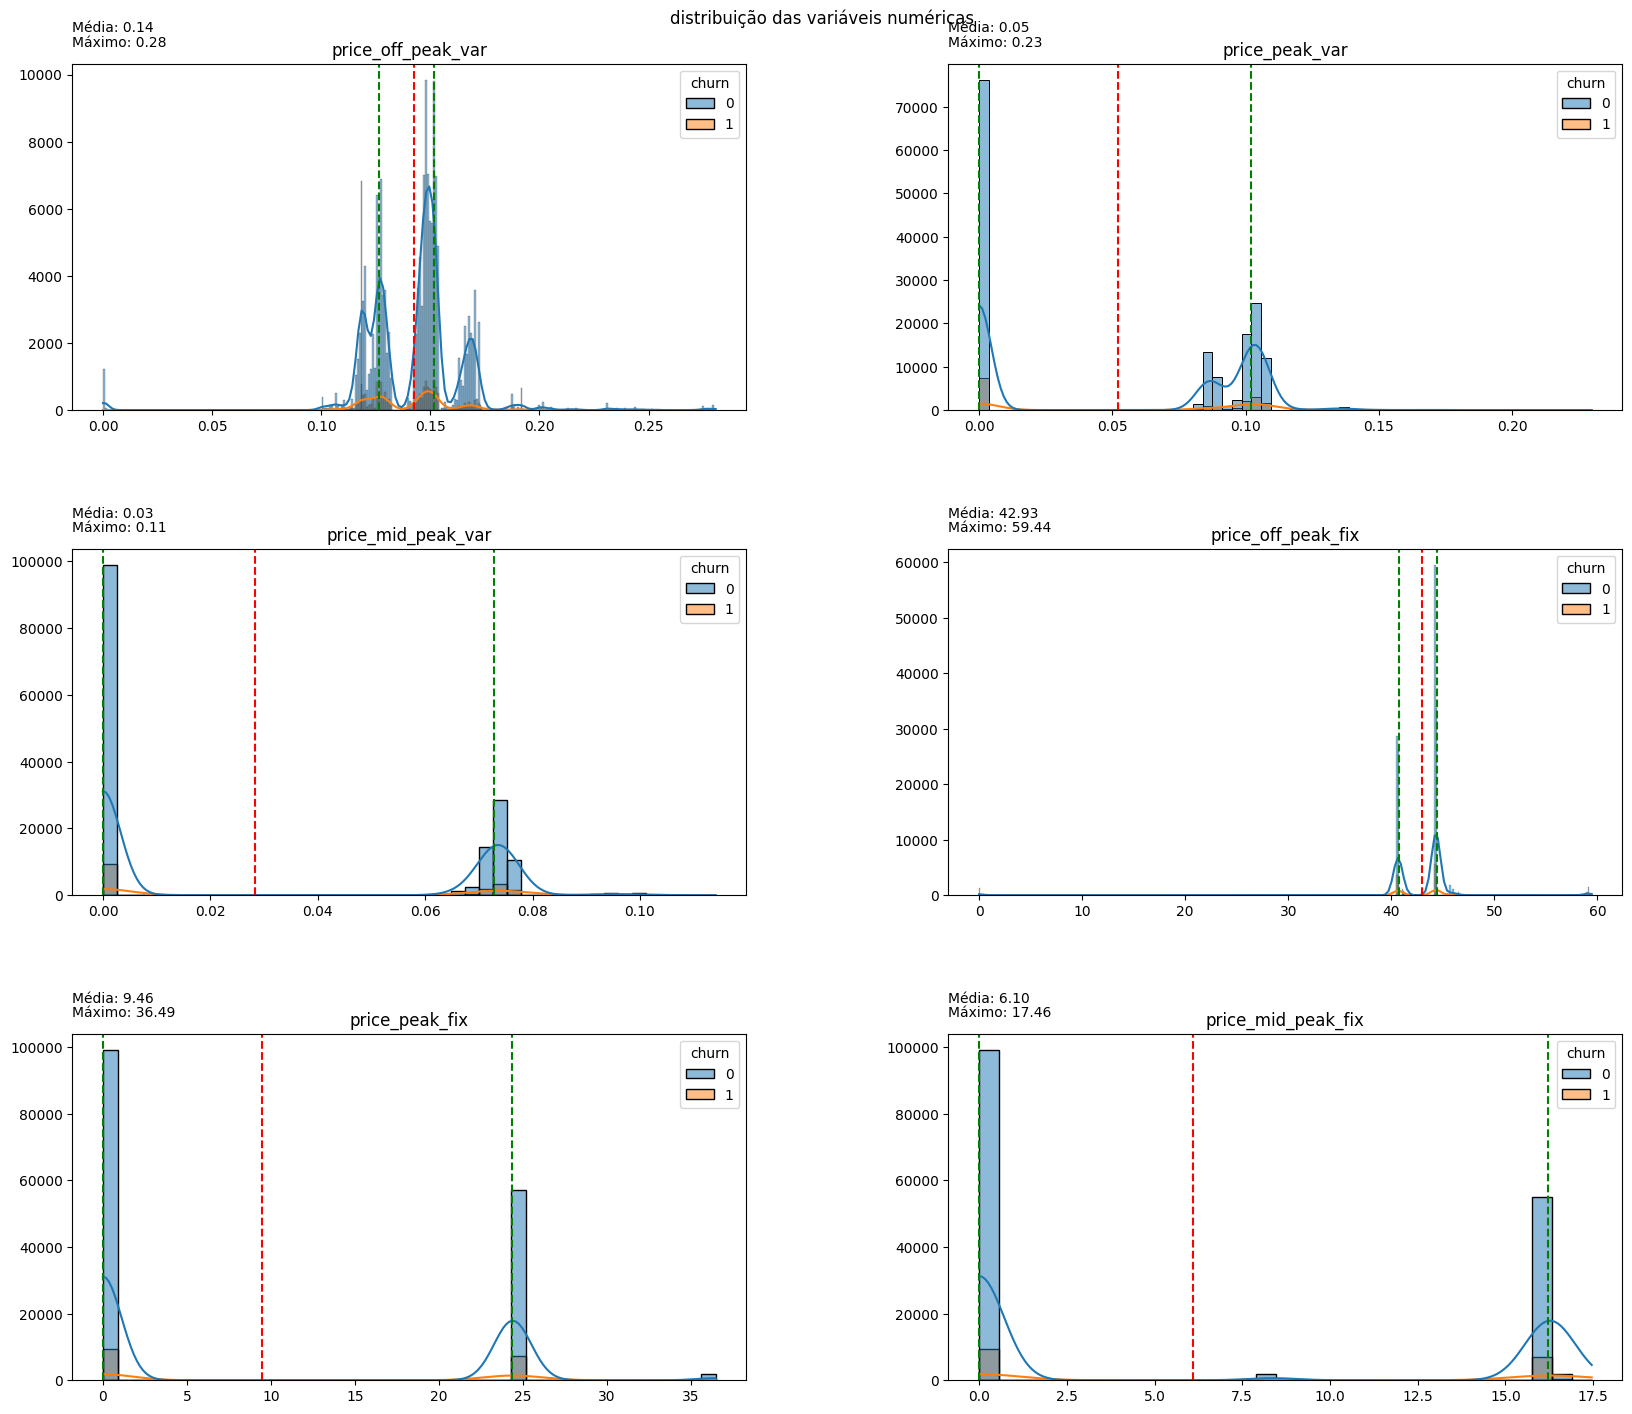

In [ ]:
for conjunto in [vars_consumption, vars_consumption_prev, vars_margin, vars_price]:
    plot_hist_variaveis(conjunto=conjunto, dataframe=df, legend='churn')

<h4>The distribution of variables indicates that the vast majority of them have a long tail to the right, indicative of outliers in all aspects. Normalizing these data may be interesting for modeling, but for now, it is more important to note the dispersion of prices: <u>the values related to on-peak and mid-peak energy indices are mostly 0, confirming the earlier hypothesis that off-peak consumption values are predominant in customer cost calculations.</u> Therefore, for price sensitivity inspection, off-peak consumption price data will be used.</h4>

<h3>4. 
Checking the price sensitivity of off-peak consumption.</h3>

In [ ]:
#Creating a new dataframe from the maximum, minimum, and mean values of each column in the price dataframe. The original dataframe contains consumption values for various dates for each ID, and this new dataframe serves as a statistical summary.
metrics_ = ['max', 'min', 'mean']

metrics_prices = df.groupby(['id']).agg(
    {
    'price_off_peak_var': metrics_,
    'price_peak_var': metrics_,
    'price_mid_peak_var': metrics_,
    'price_off_peak_fix': metrics_,
    'price_peak_fix': metrics_,
    'price_mid_peak_fix': metrics_
    }
)

#Since the dataframe was created through grouping, it is necessary to merge the first two rows into one. This way, I incorporate the variable names into the grouping type's name. 
metrics_prices.columns = ['_'.join(x) for x in zip(metrics_prices.columns.get_level_values(0), metrics_prices.columns.get_level_values(1))]
metrics_prices = metrics_prices.reset_index()

In [ ]:
#Obtaining the IDs and churn status from the customer table and adding them to the new dataframe.
metrics_prices = metrics_prices.merge(df_client[['id', 'churn']], on='id', how='left')

#Creating two new variables. The first represents the difference between the maximum and minimum values found for each registered ID, 
# while the second indicates the difference between the price of the last month with data in the database and the average price found for each registered ID.
for var in vars_price:
    metrics_prices[f'dif_max_min_{var}'] = metrics_prices[f'{var}_max'] - metrics_prices[f'{var}_min']
    metrics_prices[f'dif_last_mean_{var}'] = df_price[df_price['id'].isin(metrics_prices['id'])].groupby(['id'])[var].nth(-1).values - metrics_prices[f'{var}_mean']

#Creating columns that contain the names of the variables to use them in plotting histograms later.
dif_max_min_cols = []
dif_last_mean_cols = []
for var in vars_price:
    dif_max_min_cols.append(f'dif_max_min_{var}')
    dif_last_mean_cols.append(f'dif_last_mean_{var}')



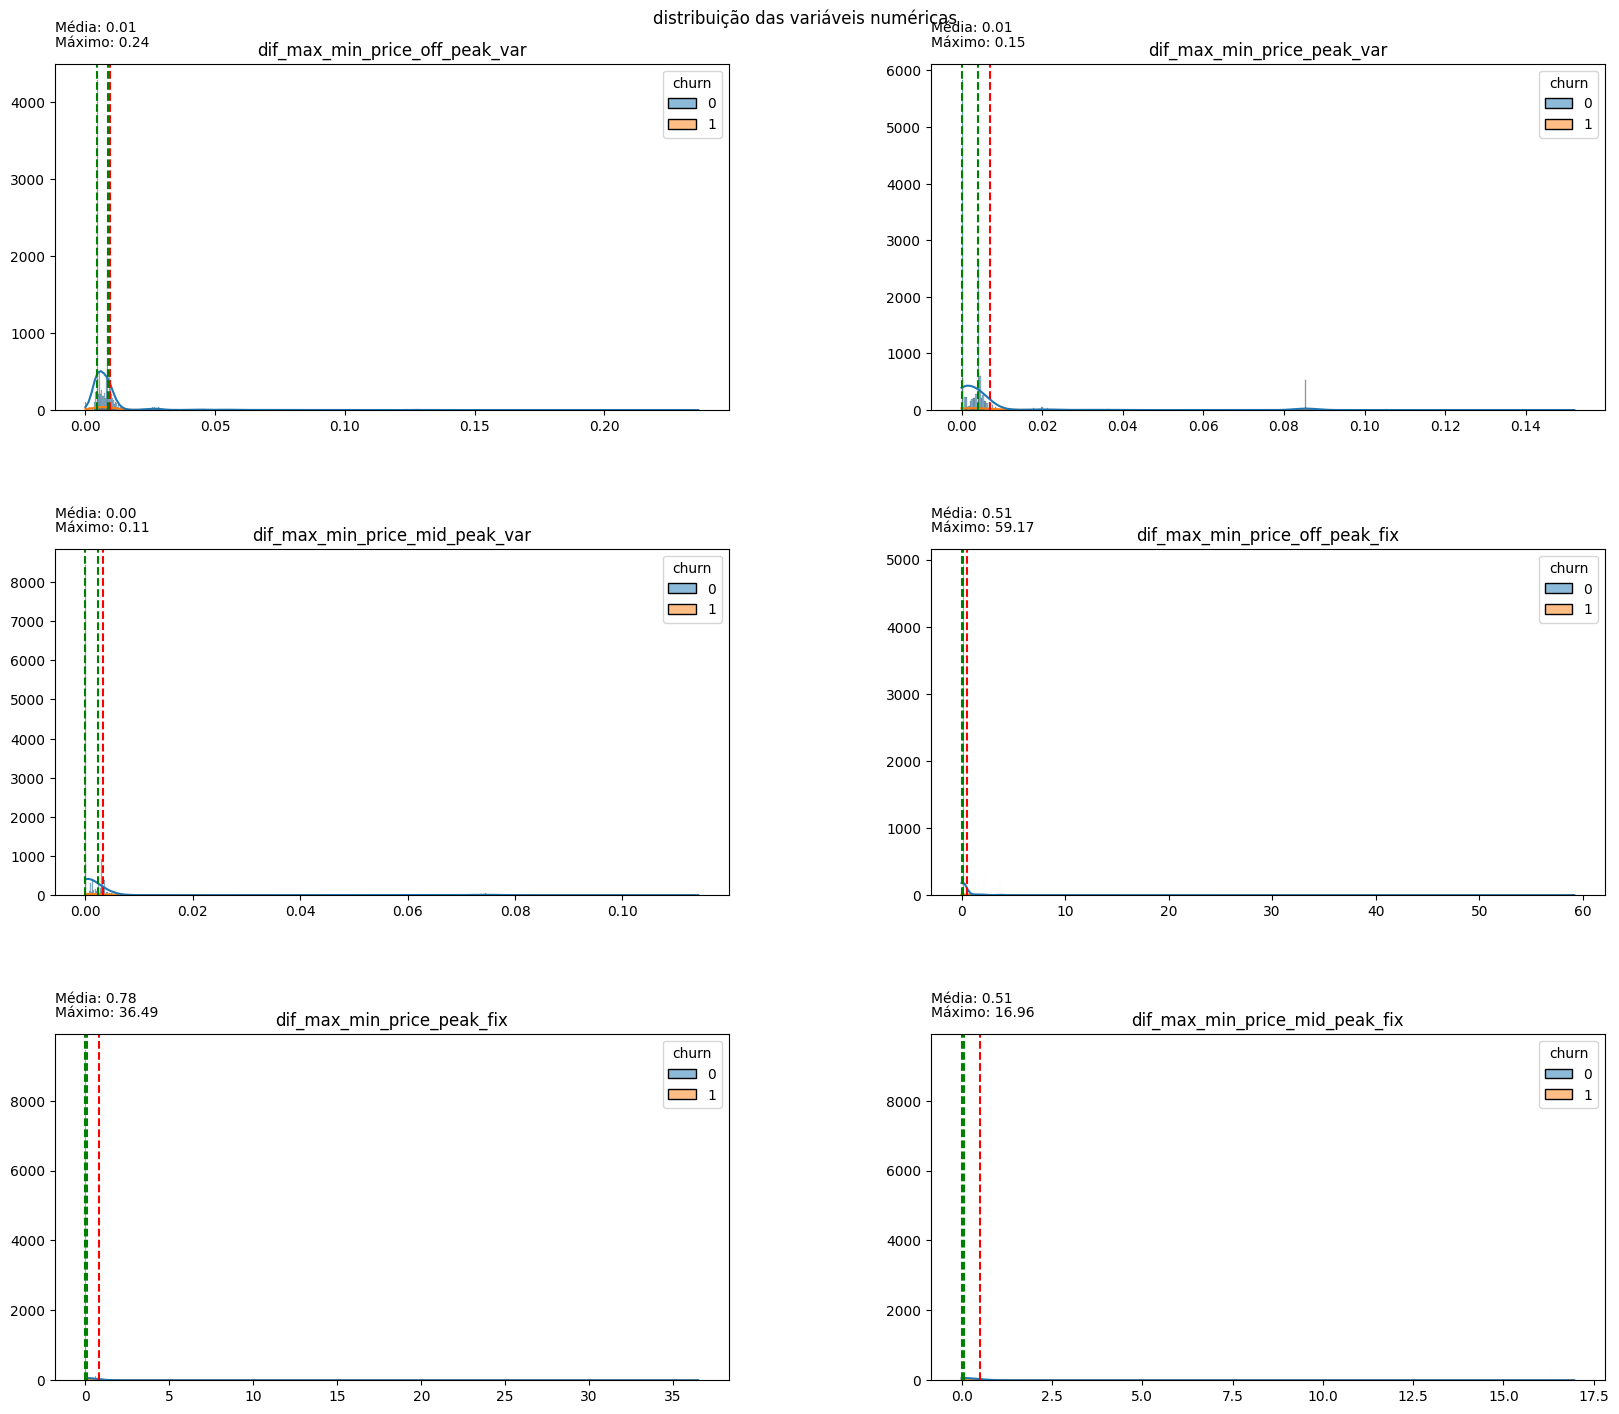

In [ ]:
plot_hist_variaveis(conjunto=dif_max_min_cols, dataframe=metrics_prices, legend='churn')

<h4>There is little difference between the maximum and minimum values for each type of consumed energy, indicating a certain <u>stability in prices over the months.</u></h4>

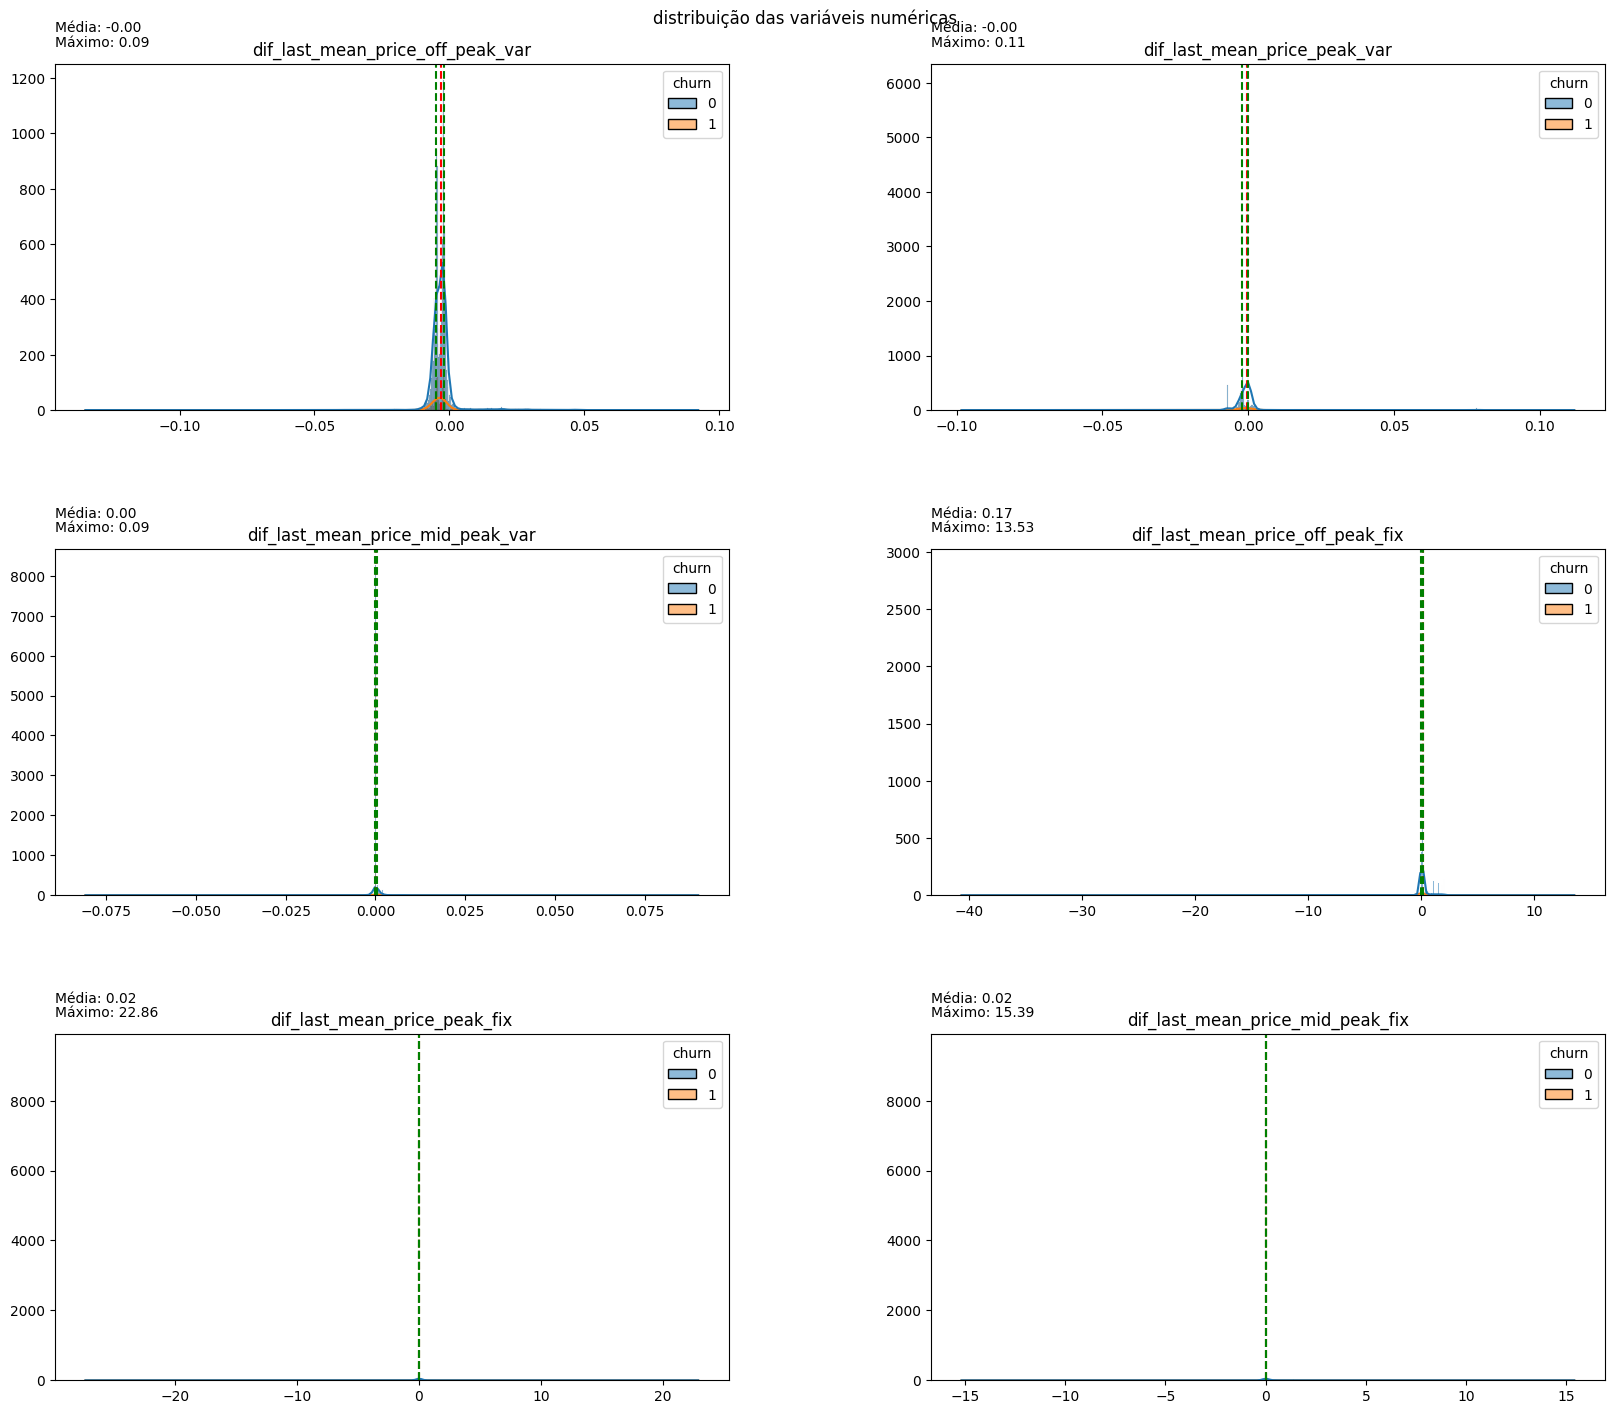

In [27]:
plot_hist_variaveis(conjunto=dif_last_mean_cols, dataframe=metrics_prices, legend='churn')

<h4>
The difference between the last month and the monthly average is close to 0 for all variables, indicating that <u>there is little difference between the price paid for consumption in the last month and the consumption of previous months.</u></h4>

<h3>5. Conclusions</h3>


- Approximately 9.71% of customers churned.
- Campaign 1 had the highest success rate in customer retention.
- Approximately 91% of contract renewals occurred in 2015, and 93% of churn happened in 2016. The proximity between the dates suggests that the wave of contract changes and price modifications may have been crucial in determining churn.
- Most customer consumption occurs in the off-peak period, subject to high price variation in 2015, especially in the months leading up to the change in energy market legislation. The price variation in off-peak power consumption may be related to customer dissatisfaction after contract renewal or before market liberalization.
- Customers who churned had contracted similar amounts of energy compared to those who did not churn but consumed significantly less energy in the last 12 months. The decrease in consumption may be related to occupation, area, or even price increases, but additional variables are needed to confirm.
- PowerCo's profit margin was higher among customers who churned, allowing for the creation of promotions and discounts in this segment to prevent customer abandonment. However, discounts should be prioritized for customers with a high profit margin.
- There is significant disparity in customer characteristics, and histograms have a long tail.
- Prices are stable over the months, and there is not a considerable variation in the amount paid in the last month by customers.